In [1]:
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 

# Parameters

In [2]:
#TODO Test and show results on Forest Cover Dataset 
dataset='ElectricDevices'

# Load Data

In [3]:
# Train Test Val Split
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x = train_x.reshape(-1,1,  train_x.shape[-2])
test_x = test_x.reshape(-1,1,  test_x.shape[-2])


In [4]:
print(test_y.shape)

(7711,)


In [5]:
enc1=pickle.load(open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [6]:
full_x= np.vstack([train_x, test_x])
full_y= np.vstack([train_y, test_y])

In [7]:
# New Train/ Test Split with 0.33
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( full_x, full_y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.33, random_state=42)

# Model Training

In [8]:
#TODO Load Data and make this new
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(X_train.astype(np.float64),y_train.astype(np.int64))
test_dataset = UCRDataset(X_test.astype(np.float64),y_test.astype(np.int64))
val_dataset = UCRDataset(X_val.astype(np.float64),y_val.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=256,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=256,shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
model.eval()

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 64, kernel_size=(1,)

In [9]:
#from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
#exp_model=TSInsightPYT(model,(train_x.shape[-2],train_x.shape[-1]),(train_x,train_y), (test_x,test_y), autoencoder='cnn')


# Explanation Algo

In [10]:
from TSInterpret.InterpretabilityModels.TSInsight.PYT_AE.CNN_PYT import ConvAutoencoder
from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
#TODO make model decision according to val !
autoencoder= ConvAutoencoder(1)
autoencoder.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_cnn'))
exp_model=TSInsightPYT(model,(train_x.shape[-2],train_x.shape[-1]),(train_x,train_y), (test_x,test_y), autoencoder=autoencoder)

2022-08-02 16:47:23.449930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 16:47:23.449953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<class 'TSInterpret.InterpretabilityModels.TSInsight.PYT_AE.CNN_PYT.ConvAutoencoder'>
Check cnn
cnn ae flag True
cnn_model True
INFO - Provided Datasets are Tuples. Create a Default DataLoader.
Epoch: 0, Fine Tune Loss: 6.377, consits of 1.1722784042358398, 0.04569876194000244, 0.006065641064196825, 5.152510166168213
Epoch: 0, Fine Validation Loss: 7.636, consits of 2.4743590354919434, 0.007291880901902914, 0.0017619561403989792, 5.152510166168213
Epoch: 1, Fine Tune Loss: 14.923, consits of 7.2167887687683105, 3.4006214141845703, 0.013879510574042797, 4.291740894317627
Epoch: 1, Fine Validation Loss: 6.49, consits of 2.049236297607422, 0.14694486558437347, 0.0025658647064119577, 4.291740894317627
Epoch: 2, Fine Tune Loss: 5.662, consits of 1.406614065170288, 0.35838115215301514, 0.008036233484745026, 3.8892605304718018
Epoch: 2, Fine Validation Loss: 6.081, consits of 2.0104377269744873, 0.17823849618434906, 0.0029041776433587074, 3.8892605304718018
Epoch: 3, Fine Tune Loss: 11.766, c

In [11]:
#from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
#exp_model=TSInsightPYT(model,(shape[-2],shape[-1]),train_loader, test_loader, autoencoder='cnn')

In [12]:
# save model 
#torch.save(exp_model.autoencoder.state_dict(), f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_cnn')

In [13]:
item=X_val[0].reshape(1,1,-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
#y_target= model(_item).detach().numpy()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

In [14]:
exp=exp_model.explain(item)

In [15]:
np.count_nonzero(item.flatten()-exp.flatten())

96

In [16]:
exp.shape

(1, 1, 96)

In [17]:
item.shape

(1, 1, 96)

(1, 1, 96)
(1, 1, 96)


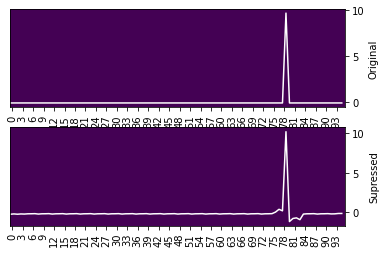

In [18]:
#TODO scale og plot
exp_model.plot(item, exp,all_in_one=False)

(1, 1, 96)
(1, 1, 96)


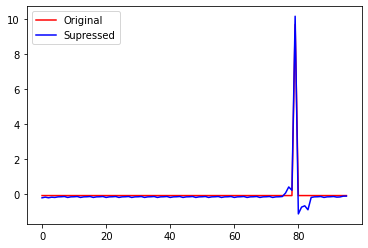

In [19]:
exp_model.plot(item, exp)

<AxesSubplot:>

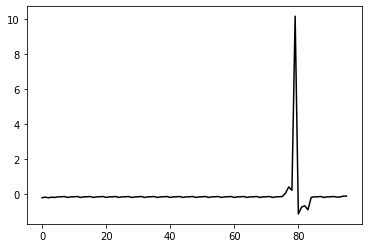

In [20]:
sns.lineplot(x=range(0,len(exp.reshape(-1))), y=exp.flatten(), color='black')